<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/04/cropped-Logo_Quantreo_transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Find best assets
The objective will be to define whether certain asset classes are more or less suitable for the strategy we propose.We will study several classes: assets, cryptos, currencies. Then we will study different characteristics like Hurst exponent, volatility, beta.

### Content
* All computations
* What assets classes is the best?
* Other optimal criterions

### Environnement

In [ ]:
!pip install ta
!pip install yfinance
!pip install hurst

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=f03d0a22487a152095201a887651467ea82fdef00d14293b6a372e5e1cf28729
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 6.3 MB 5.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a089dd5d89b2a533ac9065bf8491e86fdb17e15054dc8aa1fb6f3dacb296433f
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [ ]:
import numpy as np
import pandas as pd

import yfinance as yf
from hurst import compute_Hc
import seaborn as sns

import ta
import warnings
from tqdm import tqdm

### Functions

In [ ]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")
  
  val["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=window).rsi()


  
  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = f["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [ ]:
def beta_function(serie):

  # Get SP500 data
  sp500 = yf.download("^GSPC")[["Adj Close"]].pct_change(1)

  # Change column name
  sp500.columns = ["SP500"]

  # Concatenate
  g = pd.concat((serie,sp500), axis=1)

  # Compute the beta
  beta = np.cov(g[[serie.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(g["SP500"].dropna().values)
  return beta


In [ ]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
def BackTest(serie):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((return_serie,sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum(), color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum(), color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()




  # Compute the sortino
  sortino = np.sqrt(252) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")

# Section1:  Computations

### Whats Hurst Exponent?

The Hurst exponent is a statistic that helps to understand the behavior of a TimeSeries.

* 0.5<Hurst <1: Trending movement
* 0.5 = Hurst: Random walk
* 0<Hurst<0.5: Antipersitent movement

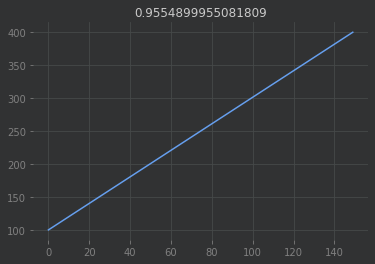

In [ ]:
# Trending
# Compute Hurst Exponent
arr = np.linspace(0,300,150)+100
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

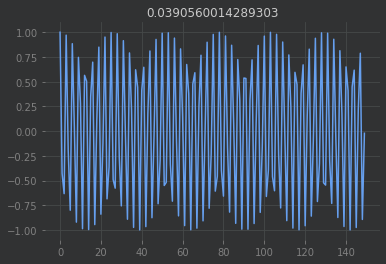

In [ ]:
# Antipersistent
# Compute Hurst Exponent
arr = np.cos(np.linspace(0,300,150))
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

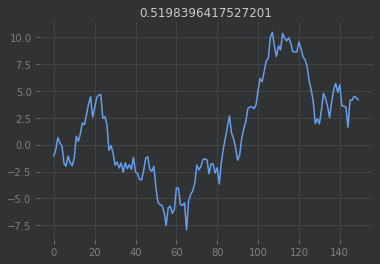

In [ ]:
# Random
# Compute Hurst Exponent
np.random.seed(56)
arr = np.cumsum(np.random.randn(150))
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

### Computations

In [ ]:
# We dowload Names.csv because it contains many yahoo ticler
assets = pd.read_csv("/content/Names.csv")["Symbol"]

# Initialize our lists
Statistics = []
col = []

for fin in tqdm(assets):

  # We put try for the asset which have less than 100 values
  try:
    print(fin)
    
    # We download data for each asset
    f = yf.download(fin).dropna()

    # Create a list to put the following statistics
    statistics = list()

    # Compute the Hurst
    statistics.append(compute_Hc(f["Adj Close"])[0])

    # Compute the volatility
    statistics.append(np.sqrt(252)*f["Adj Close"].pct_change(1).dropna().std())

    # Compute the beta
    statistics.append(beta_function(f["Adj Close"].pct_change(1).dropna()))

    # Compute strat return
    statistics.append(RSI(f,5,14).mean()*252)

    # Put statistics list in Statistics to have a list of lists
    Statistics.append(statistics)
    
    # Put column name in the list because some columns dont have 100 values
    col.append(fin)
  
  # If the assets has not 100 values we pass to the next
  except:
    pass


# We create dataframe with all the previous statistics
resume = pd.DataFrame(Statistics, columns=["Hurst", "Volatility", "Beta", "Sum strategy Returns"], index=col)
resume

  0%|          | 0/152 [00:00<?, ?it/s]

EURUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|          | 1/152 [00:01<04:23,  1.75s/it]


EURGBP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|▏         | 2/152 [00:03<04:10,  1.67s/it]


EURCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 3/152 [00:04<03:59,  1.60s/it]


EURCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 4/152 [00:06<04:04,  1.65s/it]


EURCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 5/152 [00:08<03:54,  1.60s/it]


EURJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  4%|▍         | 6/152 [00:09<03:54,  1.61s/it]


EURSEK=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▍         | 7/152 [00:11<03:57,  1.64s/it]


EURHUF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▌         | 8/152 [00:12<03:46,  1.57s/it]


GBPUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 9/152 [00:14<03:43,  1.56s/it]


GBPCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 10/152 [00:15<03:41,  1.56s/it]


GBPJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 11/152 [00:17<03:42,  1.57s/it]


USDCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 12/152 [00:19<03:41,  1.58s/it]


USDCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▊         | 13/152 [00:20<03:35,  1.55s/it]


USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 14/152 [00:22<03:33,  1.55s/it]


USDHKD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 15/152 [00:23<03:34,  1.57s/it]


USDSGD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 16/152 [00:25<03:36,  1.59s/it]


USDINR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 17/152 [00:27<03:34,  1.59s/it]


USDMXN=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 18/152 [00:28<03:29,  1.57s/it]


USDPHP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▎        | 19/152 [00:30<03:26,  1.55s/it]


USDTHB=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 20/152 [00:31<03:23,  1.55s/it]


USDMYR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 21/152 [00:33<03:22,  1.55s/it]


USDZAR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 22/152 [00:34<03:23,  1.57s/it]


USDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 23/152 [00:36<03:26,  1.60s/it]


AUDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 24/152 [00:37<03:22,  1.58s/it]


NZDUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 25/152 [00:39<03:20,  1.58s/it]


BTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 26/152 [00:40<03:12,  1.52s/it]


ETH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 27/152 [00:42<03:08,  1.51s/it]


BNB-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 28/152 [00:43<03:03,  1.48s/it]


USDT-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 29/152 [00:45<02:59,  1.46s/it]


XRP-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 30/152 [00:46<02:57,  1.46s/it]


ADA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|██        | 31/152 [00:48<02:56,  1.46s/it]


DOGE-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 21%|██        | 32/152 [00:49<02:56,  1.47s/it]


DOT1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 33/152 [00:50<02:49,  1.42s/it]


UNI3-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 34/152 [00:52<02:40,  1.36s/it]


LTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 35/152 [00:53<02:43,  1.39s/it]


BCH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 36/152 [00:54<02:40,  1.38s/it]


LINK-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 37/152 [00:56<02:41,  1.40s/it]


VET-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 38/152 [00:57<02:38,  1.39s/it]


USDC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 39/152 [00:59<02:37,  1.39s/it]


SOL1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 40/152 [01:00<02:37,  1.41s/it]


XLM-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 41/152 [01:02<02:37,  1.42s/it]


FIL-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 42/152 [01:03<02:35,  1.42s/it]


THETA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 43/152 [01:04<02:36,  1.43s/it]


TRX-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 44/152 [01:06<02:38,  1.47s/it]


XMR-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 45/152 [01:07<02:36,  1.46s/it]


LUNA1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|███       | 46/152 [01:09<02:30,  1.42s/it]


NEO-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 31%|███       | 47/152 [01:10<02:28,  1.41s/it]


EOS-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 48/152 [01:12<02:33,  1.48s/it]


MIOTA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 49/152 [01:13<02:27,  1.43s/it]


BSV-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 50/152 [01:15<02:24,  1.42s/it]


AAPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 51/152 [01:16<02:32,  1.51s/it]


MSFT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 52/152 [01:18<02:35,  1.55s/it]


AMZN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 53/152 [01:19<02:32,  1.54s/it]


TSLA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 54/152 [01:21<02:29,  1.52s/it]


FB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 55/152 [01:22<02:23,  1.48s/it]


GOOG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 56/152 [01:24<02:24,  1.51s/it]


GOOGL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 57/152 [01:25<02:23,  1.52s/it]


NVDA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 58/152 [01:27<02:20,  1.50s/it]


PYPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 59/152 [01:28<02:17,  1.48s/it]


INTC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 60/152 [01:30<02:20,  1.53s/it]


CMCSA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 40%|████      | 61/152 [01:32<02:27,  1.62s/it]


NFLX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████      | 62/152 [01:33<02:20,  1.56s/it]


ADBE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 63/152 [01:35<02:19,  1.57s/it]


CSCO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 64/152 [01:36<02:17,  1.56s/it]


PEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 65/152 [01:38<02:23,  1.65s/it]


AVGO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 66/152 [01:40<02:15,  1.57s/it]


TXN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 67/152 [01:41<02:19,  1.64s/it]


TMUS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 68/152 [01:43<02:14,  1.61s/it]


COST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 69/152 [01:44<02:13,  1.61s/it]


QCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 70/152 [01:46<02:10,  1.59s/it]


AMGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 71/152 [01:48<02:11,  1.62s/it]


SBUX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 72/152 [01:49<02:07,  1.60s/it]


AMAT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 73/152 [01:51<02:10,  1.65s/it]


CHTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 74/152 [01:52<02:02,  1.56s/it]


INTU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 75/152 [01:54<02:01,  1.58s/it]


MU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 76/152 [01:56<01:59,  1.57s/it]


BKNG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 77/152 [01:57<01:58,  1.58s/it]


AMD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 78/152 [01:59<01:57,  1.58s/it]


LRCX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 79/152 [02:01<01:59,  1.64s/it]


ISRG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 80/152 [02:02<01:58,  1.64s/it]


MDLZ
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 81/152 [02:04<01:55,  1.63s/it]


GILD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 82/152 [02:05<01:53,  1.62s/it]


FISV
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 83/152 [02:07<01:50,  1.60s/it]


ADP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 84/152 [02:09<01:52,  1.66s/it]


ZM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 85/152 [02:10<01:42,  1.53s/it]


MELI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 86/152 [02:11<01:40,  1.53s/it]


ATVI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 87/152 [02:13<01:40,  1.54s/it]


CSX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 88/152 [02:15<01:42,  1.60s/it]


JD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 89/152 [02:16<01:36,  1.53s/it]


ADSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 90/152 [02:18<01:37,  1.57s/it]


BIDU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 91/152 [02:19<01:33,  1.53s/it]


ILMN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 92/152 [02:21<01:31,  1.52s/it]


ADI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 93/152 [02:23<01:34,  1.60s/it]


NXPI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 94/152 [02:24<01:30,  1.56s/it]


VRTX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▎   | 95/152 [02:26<01:29,  1.57s/it]


KLAC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 96/152 [02:27<01:29,  1.59s/it]


MRNA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 97/152 [02:29<01:24,  1.54s/it]


PDD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 98/152 [02:30<01:18,  1.46s/it]


REGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 99/152 [02:32<01:19,  1.50s/it]


KHC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 100/152 [02:33<01:15,  1.44s/it]


MNST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 101/152 [02:34<01:16,  1.49s/it]


KDP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 102/152 [02:36<01:13,  1.47s/it]


MAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 103/152 [02:38<01:15,  1.53s/it]


ASML
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 104/152 [02:39<01:13,  1.54s/it]


WBA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 105/152 [02:41<01:15,  1.61s/it]


WDAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 106/152 [02:42<01:12,  1.58s/it]


ROST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|███████   | 107/152 [02:44<01:12,  1.62s/it]


ALGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 108/152 [02:46<01:12,  1.66s/it]


EXC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 109/152 [02:48<01:12,  1.69s/it]


MCHP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 110/152 [02:49<01:09,  1.66s/it]


AEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 111/152 [02:51<01:12,  1.76s/it]


EBAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 112/152 [02:53<01:07,  1.68s/it]


CTSH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 113/152 [02:54<01:03,  1.64s/it]


IDXX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 114/152 [02:56<01:02,  1.64s/it]


BIIB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 115/152 [02:58<01:01,  1.67s/it]


EA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 116/152 [02:59<00:59,  1.66s/it]


CDNS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 117/152 [03:01<00:56,  1.62s/it]


SNPS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 118/152 [03:02<00:55,  1.62s/it]


LULU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 119/152 [03:04<00:51,  1.57s/it]


MTCH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 120/152 [03:06<00:51,  1.61s/it]


DOCU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 121/152 [03:07<00:47,  1.54s/it]


XEL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 122/152 [03:09<00:48,  1.62s/it]


CTAS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 123/152 [03:10<00:46,  1.60s/it]


ORLY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 124/152 [03:12<00:45,  1.62s/it]


DXCM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 125/152 [03:13<00:42,  1.57s/it]


PAYX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 126/152 [03:15<00:41,  1.59s/it]


MRVL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 127/152 [03:17<00:39,  1.58s/it]


ALXN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 128/152 [03:18<00:37,  1.57s/it]


PCAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 129/152 [03:20<00:37,  1.62s/it]


NTES
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 130/152 [03:21<00:34,  1.59s/it]


XLNX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 131/152 [03:23<00:33,  1.59s/it]


SWKS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 132/152 [03:25<00:31,  1.59s/it]


ANSS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 133/152 [03:26<00:30,  1.62s/it]


PTON
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 134/152 [03:27<00:26,  1.50s/it]


TEAM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 135/152 [03:29<00:24,  1.46s/it]


VRSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 136/152 [03:30<00:22,  1.44s/it]


FAST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 137/152 [03:32<00:22,  1.53s/it]


OKTA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 138/152 [03:33<00:20,  1.46s/it]


DLTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 139/152 [03:35<00:19,  1.52s/it]


CPRT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 140/152 [03:36<00:18,  1.52s/it]


SGEN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 141/152 [03:38<00:16,  1.52s/it]


SIRI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 142/152 [03:40<00:15,  1.54s/it]


MXIM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 143/152 [03:41<00:14,  1.58s/it]


CDW
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 144/152 [03:43<00:12,  1.54s/it]


VRSN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 145/152 [03:44<00:10,  1.52s/it]


SPLK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 146/152 [03:46<00:08,  1.50s/it]


CERN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 147/152 [03:47<00:07,  1.55s/it]


TCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 148/152 [03:49<00:06,  1.55s/it]


INCY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 149/152 [03:50<00:04,  1.54s/it]


CHKP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 150/152 [03:52<00:03,  1.54s/it]


FOXA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 151/152 [03:53<00:01,  1.46s/it]


FOX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

100%|██████████| 152/152 [03:54<00:00,  1.55s/it]

,Hurst,Volatility,Beta,Sum strategy Returns
EURUSD=X,0.438422,0.117756,0.073611,-0.023180
EURGBP=X,0.516094,0.083017,-0.019264,-0.029603
EURCHF=X,0.541541,0.079169,0.054978,-0.017116
EURCAD=X,0.452911,0.092607,-0.049634,-0.024969
EURCNY=X,0.460816,0.131363,0.040479,-0.136572
...,...,...,...,...
TCOM,0.527149,0.506525,0.969155,-0.007461
INCY,0.506868,0.660123,1.113995,0.118113
CHKP,0.488106,0.522763,1.001643,-0.049542
FOXA,0.529212,0.396966,1.141793,-0.123534


In [ ]:
# We extract classe of the actif 
clustering = pd.read_csv("/content/Names.csv", index_col="Symbol")
del clustering["Unnamed: 0"]
clustering

,dummy
Symbol,
EURUSD=X,Currency
EURGBP=X,Currency
EURCHF=X,Currency
EURCAD=X,Currency
EURCNY=X,Currency
...,...
TCOM,Asset
INCY,Asset
CHKP,Asset


In [ ]:
# Concat resume clustering to have the classe of the assets
g = pd.concat((resume,clustering), axis=1).dropna()

# Section 2: What assets classes is the best?

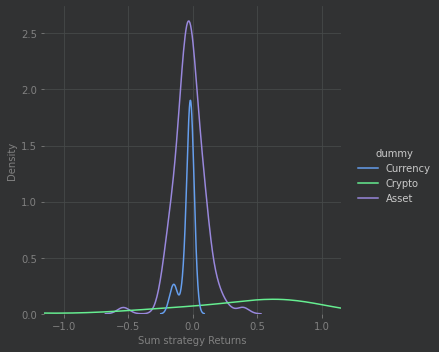

In [ ]:
# We are going to plot the density of the strategy returns by the classe of the assets


# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="dummy")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

In [ ]:
# Describe by currency
g.loc[g["dummy"]=="Currency"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,25.000000,25.000000,25.000000,25.000000
mean,0.503846,0.100792,0.006544,-0.036377
std,0.049120,0.035846,0.111204,0.047202
min,0.390274,0.010988,-0.241983,-0.172891
25%,0.468818,0.082074,-0.049634,-0.031539
50%,0.498933,0.095902,-0.000209,-0.023180
75%,0.541541,0.125910,0.065522,-0.008247
max,0.621141,0.174678,0.273566,0.014930


In [ ]:
# Describe by Crypto
g.loc[g["dummy"]=="Crypto"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,25.000000,25.000000,25.000000,25.000000
mean,0.521471,1.567595,0.810721,0.355064
std,0.054306,1.820437,0.425937,0.566392
min,0.398757,0.072355,-0.074638,-1.497277
25%,0.495635,1.125612,0.555333,0.041373
50%,0.522609,1.274945,0.803642,0.516719
75%,0.550171,1.425528,1.141478,0.737998
max,0.667664,10.011799,1.513758,0.992145


In [ ]:
# Describe by asset
g.loc[g["dummy"]=="Asset"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,102.000000,102.000000,102.000000,102.000000
mean,0.563200,0.461123,0.863337,-0.027619
std,0.038384,0.135912,0.236596,0.117118
min,0.482708,0.208017,0.121251,-0.536733
25%,0.534451,0.360926,0.708712,-0.085622
50%,0.562091,0.465199,0.879522,-0.027801
75%,0.591385,0.554754,1.019213,0.033857
max,0.656422,0.826443,1.441015,0.389377


# Section 3: Other optimal criterions

In [ ]:
g.describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,152.000000,152.000000,152.000000,152.000000
mean,0.546575,0.583844,0.713763,0.033882
std,0.049306,0.865054,0.409535,0.284549
min,0.390274,0.010988,-0.241983,-1.497277
25%,0.515940,0.294263,0.516338,-0.081500
50%,0.547901,0.454344,0.809117,-0.016883
75%,0.577066,0.586649,0.991561,0.054065
max,0.667664,10.011799,1.513758,0.992145


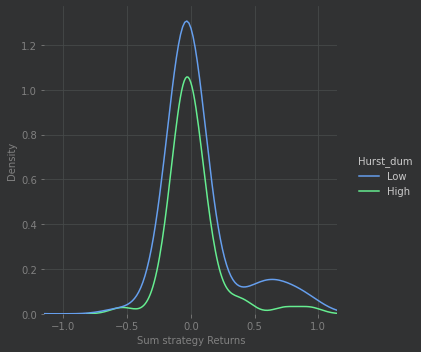

In [ ]:
# We are going to plot the density of the strategy returns by the HURST
g["Hurst_dum"] = "Low"
g.loc[g["Hurst"]>0.56, "Hurst_dum"] = "High"

# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Hurst_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

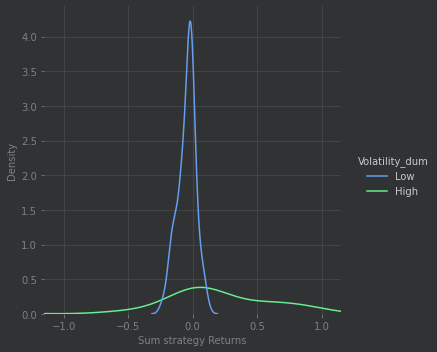

In [ ]:
# We are going to plot the density of the strategy returns by the classe of the assets
g["Volatility_dum"] = "Low"
g.loc[g["Volatility"]>0.52,"Volatility_dum"] = "High"
# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Volatility_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

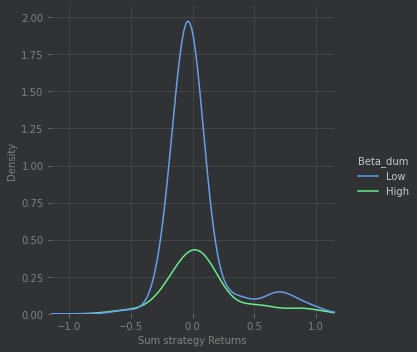

In [ ]:
# We are going to plot the density of the strategy returns by the classe of the assets
g["Beta_dum"] = "Low"
g.loc[g["Beta"]>1,"Beta_dum"] = "High"
# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Beta_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()